## Trying to even figure out the drawing of the boundary

In [20]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works
        self.observation_space = spaces.Box(low=0, high=3, dtype=np.int8)
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return planting_grid, planting_coords, dithered_perlin_env


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self):
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()
        pass


    def step(self):
        pass

In [21]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(5)])


[0.26363423 0.14176004 0.2995702 ]
[6 6]


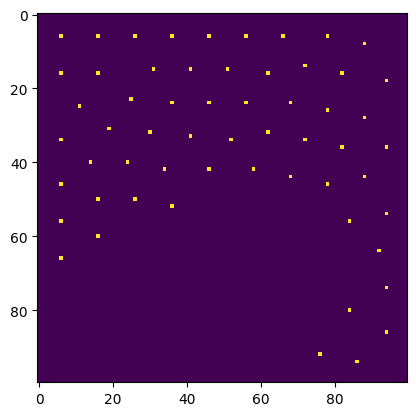

In [22]:
import matplotlib.pyplot as plt
# TEST EXAMPLE
test = customSpatialEnv(1.23)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
plt.imshow(test.grid) #grid

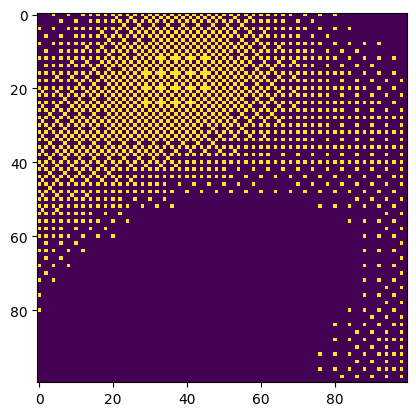

In [23]:
plt.imshow(test.unfiltered_grid)

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_precise_boundary_no_approx(image_array, threshold_value=128, contour_color=(0, 255, 0), contour_thickness=1, dilation_iterations=4):
    '''
    Draws a precise boundary around all yellow regions in the given image without approximating contours.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_color: tuple -- the color of the boundary in BGR (default: green).
    - contour_thickness: int -- the thickness of the boundary (default: 1 for a thinner line).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 1).
    
    Returns:
    - color_image: np.array -- the image with the drawn precise boundary.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert to color image (if not already)
    color_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

    # Draw the contours on the original image with the specified thickness
    cv2.drawContours(color_image, contours, -1, contour_color, contour_thickness)

    # Show the image with the precise boundary
    plt.imshow(color_image)
    plt.show()
    
    return color_image


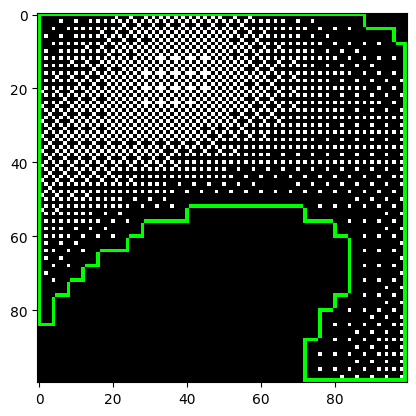

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [76]:
draw_precise_boundary_no_approx(test.unfiltered_grid)

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_and_modify_array(image_array, threshold_value=128, contour_value=255, dilation_iterations=3):
    '''
    Draws a precise boundary around all yellow regions in the given image and updates the NumPy array with the boundary values.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 1).
    
    Returns:
    - modified_array: np.array -- the modified NumPy array with the boundary values.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original normalized image to modify it with the contours
    modified_array = np.copy(normalized_image)

    # Draw the contours on the array (modifying the array directly)
    cv2.drawContours(modified_array, contours, -1, contour_value, thickness=1)

    # Show the modified array with the contours
    plt.imshow(modified_array, cmap='gray')
    plt.show()
    
    return modified_array


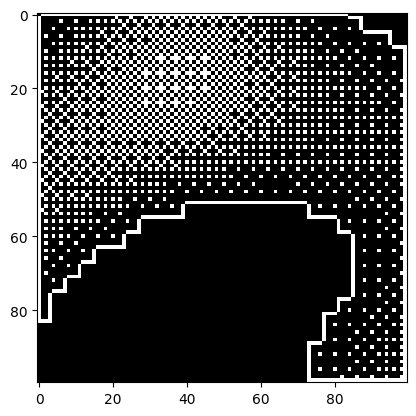

array([[  0, 255, 255, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [84]:
draw_and_modify_array(test.unfiltered_grid)

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_and_return_boundary_only(image_array, threshold_value=128, contour_value=255, dilation_iterations=3):
    '''
    Draws a precise boundary around all yellow regions in the given image and returns an array with only the boundary values.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
    
    Returns:
    - boundary_array: np.array -- the NumPy array containing only the boundary values.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty array (same shape as normalized_image) to store only the boundary
    boundary_array = np.zeros_like(normalized_image)

    # Draw the contours on the boundary array (without the original regions, only the contours)
    cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

    # Show the boundary array
    plt.imshow(boundary_array, cmap='gray')
    plt.show()
    
    return boundary_array


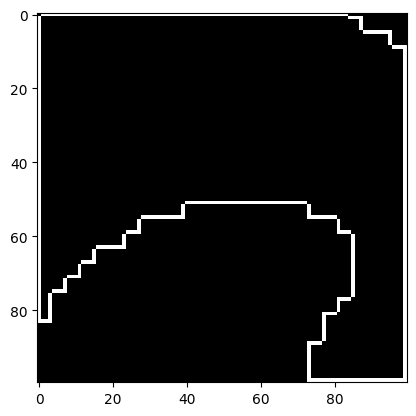

In [86]:
boundary_only_array = draw_and_return_boundary_only(test.unfiltered_grid)


## New Code with the boundary for now

In [121]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.boundary = self._create_environment()

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works
        self.observation_space = spaces.Box(low=0, high=3, dtype=np.int8)
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break


        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        

        return planting_grid, planting_coords, boundary


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self):
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()
        pass


    def step(self):
        pass

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr


In [122]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(5)])


[0.25857547 0.51259375 0.5279272 ]
[6 6]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


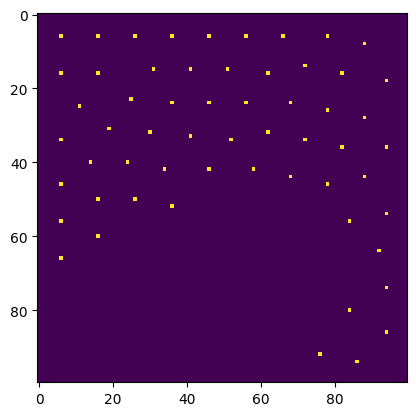

In [139]:
import matplotlib.pyplot as plt
# TEST EXAMPLE
test = customSpatialEnv(1.23)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
plt.imshow(test.grid) #grid
print(test.grid)

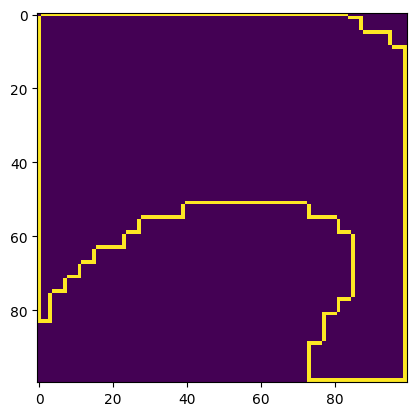

In [140]:
plt.imshow(test.boundary) #grid

## Step 2, Training a model for the using the new data